# Importing Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")
from numpy import mean
from numpy import std
from numpy import absolute

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from gensim.models import KeyedVectors


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
# Download necessary NLTK datasets
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **1. Data Preparation**

## a. Training Data Preparation

 ### Loading Training dataset

In [4]:
data = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1',
                   header=None)

In [5]:
print(data.head(2))

   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  


## Giving column names

In [6]:
data.columns=['target', 'ids', 'date', 'flag','user','text']

In [7]:
print(len(data))

1600000


In [8]:
print(data['target'].value_counts())

target
0    800000
4    800000
Name: count, dtype: int64


# Creating a subset of the Data


Due to memory constraints only 40% of the data is used for Training

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assume you have a dataframe `df` and a target column `target_column`
X = data.drop(columns=['target'])  # Features
y = data['target']  # Target

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.92, random_state=42)

# Generate stratified splits
for train_index, test_index in sss.split(X, y):
    X_sample = X.iloc[train_index]
    y_sample = y.iloc[train_index]

# Combine the sampled data back into a DataFrame
df_sampled = X_sample.copy()
df_sampled['target'] = y_sample

In [12]:
print(len(df_sampled))

128000


In [13]:
print(df_sampled['target'].value_counts())

target
4    64000
0    64000
Name: count, dtype: int64


# Text Preprocessing

Cleaning the Text, removing stop words, lemmatisation to return the root words, remove extra spaces and symbols, and converting text into a tokenised format

In [17]:
import regex as re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

class TextPreprocessing:

    def __init__(self, dataframe):

        self.df = dataframe
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()  # Using lemmatizer instead of stemmer
        self.useless_words = {'http', '.com'}

    def clean_text(self):

        ## Removing URLs, mentions, hashtags, and non-alphabetic characters
        self.df['clean_text'] = self.df['text'].apply(lambda x: re.sub(r'http[s]?://\S+|www\.\S+|\.com', '', x))
        self.df['clean_text'] = self.df['clean_text'].apply(lambda x: re.sub(r'@\w+', '', x))  # Remove mentions
        self.df['clean_text'] = self.df['clean_text'].apply(lambda x: re.sub(r'#\w+', '', x))  # Remove hashtags
        self.df['clean_text'] = self.df['clean_text'].apply(lambda x: re.sub(r'[^A-Za-z\s]', '', x))  # Remove non-alphabetic characters
        self.df['clean_text'] = self.df['clean_text'].apply(lambda x: x.lower())  # Convert to lowercase

    def tokenize(self):

        ## Tokenizing the cleaned text into words
        self.df['tokens'] = self.df['clean_text'].apply(word_tokenize)

    def remove_stopwords(self):

        ## Removing stopwords from tokens
        self.df['tokens_no_stopwords'] = self.df['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in self.stop_words])

    def lemmatize_tokens(self):

        ## Lemmatizing the tokens 
        self.df['tokens_lemmatized'] = self.df['tokens_no_stopwords'].apply(lambda tokens: [self.lemmatizer.lemmatize(word) for word in tokens])

    def remove_useless_words(self):

        ## Removing prepositions, pronouns, and other extra words
        self.df['tokens_cleaned'] = self.df['tokens_lemmatized'].apply(lambda tokens: [word for word in tokens if word.lower() not in self.useless_words])

    def preprocess(self):

        ## Apply all preprocessing steps
        self.clean_text()
        self.tokenize()
        self.remove_stopwords()
        self.lemmatize_tokens() 
        self.remove_useless_words()

        return self.df


### Applying Text Pre-Processing

In [18]:
text_processor = TextPreprocessing(df_sampled)
processed_df = text_processor.preprocess()

In [19]:
df_sampled.columns

Index(['ids', 'date', 'flag', 'user', 'text', 'target', 'clean_text', 'tokens',
       'tokens_no_stopwords', 'tokens_lemmatized', 'tokens_cleaned'],
      dtype='object')

In [20]:
df1=df_sampled[['target', 'ids', 'date', 'flag', 'user','tokens_cleaned']]

In [21]:
## Applying further preposessing 
df1['cleaned_t'] = df1['tokens_cleaned'].apply(lambda x: ' '.join(x))
df1.rename(columns={'cleaned_t': 'text_clean'}, inplace=True)
df1.drop(['tokens_cleaned'], axis=1,inplace=True)

## b. Loading the Test Data

In [22]:
data_test = pd.read_csv('/content/drive/MyDrive/testdata.manual.2009.06.14.csv', header=None)

In [56]:
df_test= data_test.copy()

In [57]:
df_test.columns=['target', 'ids', 'date', 'flag','user','text']

In [25]:
#df_training.target.value_counts()

In [26]:
print(df_test.target.value_counts())

target
4    182
0    177
2    139
Name: count, dtype: int64


### Applying Pre-processing

In [58]:
text_processor_test = TextPreprocessing(df_test)
processed_test = text_processor_test.preprocess()

## Generating new Text rows with target=2, using synonyms - to be used in Training

In [28]:
df_target2=df_test[df_test.target==2]

In [29]:
import random
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

# Simple synonym replacement function
def synonym_replacement(text):
    words = text
    new_words = []

    for word in words:
        # Get synonyms for the word using WordNet
        synonyms = wordnet.synsets(word)

        # If no synonym found, use the word itself
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words.append(synonym)
        else:
            new_words.append(word)

    # Return the augmented text
    return ' '.join(new_words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [30]:
df_target2['augmented_text'] = df_target2['tokens_cleaned'].apply(synonym_replacement)

print("Original and Augmented Data:")
print(df_target2[['clean_text', 'augmented_text']])

Original and Augmented Data:
                                            clean_text  \
10   check this video out  president obama at the w...   
30   need suggestions for a good ir filter for my c...   
31    i just checked my google for my business blip...   
45              is in san francisco at bay to breakers   
46                        just landed at san francisco   
..                                                 ...   
475  has a date with bobby flay and gut fieri from ...   
483               how to track iran with social media    
486  twitter stock buzz aapl esf spy spx palm  upda...   
488                          is bobby flay joining you   
493  ask programming latex or indesign submitted by...   

                                        augmented_text  
10   check video_recording president obama White th...  
30   indigence suggestion good iridium filter canyo...  
31   control google business blip usher second subm...  
45                   san francisco bay circuit

In [31]:
print(df_target2.columns)

Index(['target', 'ids', 'date', 'flag', 'user', 'text', 'clean_text', 'tokens',
       'tokens_no_stopwords', 'tokens_lemmatized', 'tokens_cleaned',
       'augmented_text'],
      dtype='object')


## Using Similarity ratio

Selecting only those rows where the generated text is not equal to the actual text by less than 40%

In [32]:

# Function to calculate Jaccard Similarity
def jaccard_similarity(tokens_cleaned, augmented_text):
    # Tokenize the augmented text (split by spaces)
    augmented_tokens = augmented_text.split()

    # Convert both lists to sets to eliminate duplicates
    set_cleaned = set(tokens_cleaned)
    set_augmented = set(augmented_tokens)

    # Calculate the intersection and union
    intersection = len(set_cleaned.intersection(set_augmented))
    union = len(set_cleaned.union(set_augmented))

    # Return the Jaccard Similarity
    return intersection / union if union != 0 else 0

# Apply the Jaccard similarity function row-wise and create a similarity column
df_target2['similarity_ratio'] = df_target2.apply(
    lambda row: jaccard_similarity(row['tokens_cleaned'], row['augmented_text']),
    axis=1
)

print(df_target2[['tokens_cleaned', 'augmented_text', 'similarity_ratio']])


                                        tokens_cleaned  \
10   [check, video, president, obama, white, house,...   
30   [need, suggestion, good, ir, filter, canon, go...   
31   [checked, google, business, blip, show, second...   
45                      [san, francisco, bay, breaker]   
46                            [landed, san, francisco]   
..                                                 ...   
475     [date, bobby, flay, gut, fieri, food, network]   
483                      [track, iran, social, medium]   
486  [twitter, stock, buzz, aapl, esf, spy, spx, pa...   
488                             [bobby, flay, joining]   
493  [ask, programming, latex, indesign, submitted,...   

                                        augmented_text  similarity_ratio  
10   check video_recording president obama White th...          0.454545  
30   indigence suggestion good iridium filter canyo...          0.285714  
31   control google business blip usher second subm...          0.428571  
45 

In [33]:
df_training_merge= df_target2[df_target2['similarity_ratio']<0.4][['target', 'ids', 'date', 'flag', 'user','augmented_text']]

## Renaming columns similar to the Training Data

In [34]:
df_training_merge.rename(columns={'augmented_text':'text_clean'}, inplace=True)

## Combining generated Text for Target class 2 with Training Data

In [35]:
df_training=pd.concat([df1,df_training_merge])

In [36]:
print(df_training.target.value_counts())

target
4    64000
0    64000
2       57
Name: count, dtype: int64


In [ ]:
#df_training['text_clean'].values

# 2. Visualising the Data

Note: Visualisation was performed on a larger data size, the datasize was reduced for the modelling purposes

## a. Wordcloud

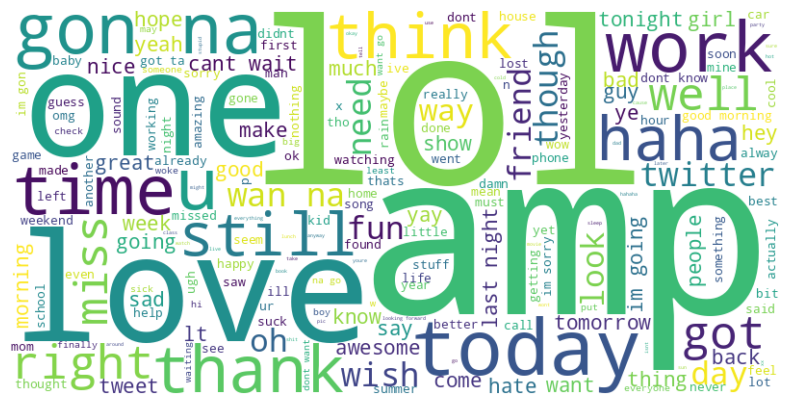

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Flatten the list of sentences in df['text_clean'] into a single string
all_text = ' '.join(df_training['text_clean'].values)  # Join all the text from 'text_clean' column into one large string

# 2. Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# 3. Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## b. Frequency Chart

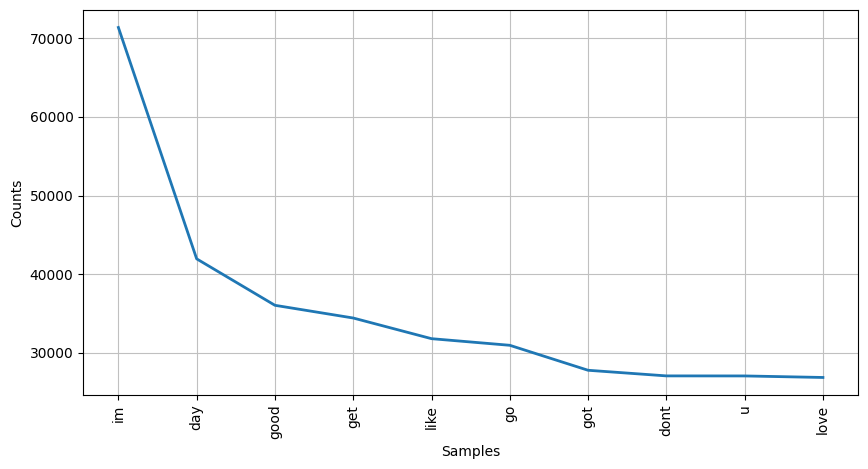

In [ ]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# 1. Flatten the list of strings in df['text_clean'] into a list of tokens
# Tokenize each sentence in 'text_clean' to get individual words
all_tokens_cleaned = [word for sentence in df_training['text_clean'] for word in word_tokenize(sentence.lower())]

# 2. Get the frequency distribution of the tokens
fdist = FreqDist(all_tokens_cleaned)

# 3. Plot the frequency distribution of the top 10 most common words
plt.figure(figsize=(10, 5))
fdist.plot(10, cumulative=False)
plt.show()

# Data Prepartion for Modelling

## Oversampling of Data to make the proportion of Minority class(Target=2) balanced

In [37]:
import pandas as pd
from sklearn.utils import resample

## Defining the target value with the least count (minority class)
minority_class_value = df_training['target'].value_counts().idxmin()

## Extracting the minority class based on that value
minority_class = df_training[df_training['target'] == minority_class_value]

## Extracting the majority class (all rows not in the minority class)
majority_class = df_training[df_training['target'] != minority_class_value]

## Oversampling the minority class to match the size of the majority class
minority_upsampled = resample(minority_class,
                              replace=True,
                              n_samples=len(majority_class)//2,
                              random_state=42)

## Combining the majority class and the upsampled minority class
train_data_balanced = pd.concat([majority_class, minority_upsampled])

## Checking the balanced dataset
print(train_data_balanced['target'].value_counts())


target
4    64000
0    64000
2    64000
Name: count, dtype: int64


## Defining Features and Target

In [38]:
features = train_data_balanced['text_clean']
target = train_data_balanced['target']

## Defining Text Classification Models

## NB Classifier

In addition to the models required as part of the Asssignment, I applied NB Classifier on 40% of the Data. For all the other models just 7% of the data was considered due to memory constraints

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

class TextClassifier:

    def __init__(self, df, target_column):
        """Initialize with dataframe and target column."""
        self.df = df
        self.target_column = target_column
        self.vectorizer = TfidfVectorizer(max_features=5000)  # TF-IDF vectorizer
        self.classifier = MultinomialNB()  # Multinomial Naive Bayes classifier

    def train_model(self):
        """Train the model with the cleaned and vectorized data."""
        X = self.df['text_clean']  # Assuming you have a column with cleaned text
        y = self.df[self.target_column]

        # Split data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Vectorize the text data
        X_train_bow = self.vectorizer.fit_transform(X_train)
        X_test_bow = self.vectorizer.transform(X_test)

        # Train the MultinomialNB model
        self.classifier.fit(X_train_bow, y_train)

        # Predict on the test set
        y_pred = self.classifier.predict(X_test_bow)

        # Evaluate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")

        # Print the classification report
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        return X_test, y_test, y_pred  # Returning for further evaluation

    def predict(self, new_data):
        """Predict labels for new data."""
        new_data_bow = self.vectorizer.transform(new_data)
        return self.classifier.predict(new_data_bow)

    def evaluate_predictions(self, new_data, true_labels):
        """Evaluate predictions on new data with true labels."""
        y_pred = self.predict(new_data)
        return accuracy_score(true_labels, y_pred)

    def fit_and_evaluate(self):
        """Fit the model and evaluate on the test set."""
        # Train the model and get test set results
        X_test, y_test, y_pred = self.train_model()

        # Return predictions, true labels, and features for further analysis
        return X_test, y_test, y_pred


In [ ]:

# Initialize the TextClassifier class
text_classifier = TextClassifier(train_data_balanced, target_column='target')

# Preprocess the data, train the model and evaluate
text_classifier.fit_and_evaluate()


Accuracy: 0.8378
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     64050
           2       0.99      1.00      1.00     64022
           4       0.76      0.76      0.76     63928

    accuracy                           0.84    192000
   macro avg       0.84      0.84      0.84    192000
weighted avg       0.84      0.84      0.84    192000



(1141782                               omg omg need see kstew
 1404583    new one seen though sure annoying winky smiley...
 777745     still awake even movie last night work today s...
 1462482        dude made betty crocker choc chip cooky today
 558623     finished math last week like chinese stuff kee...
                                  ...                        
 1006413                                                hello
 935131     nose itching mean someone kissing ur pic guess...
 242                                      pro surveil chitter
 510833     found little present teh cat morning thought o...
 466        miss insightfilled whitethorn column one chic ...
 Name: text_clean, Length: 192000, dtype: object,
 1141782    4
 1404583    4
 777745     0
 1462482    4
 558623     0
           ..
 1006413    4
 935131     4
 242        2
 510833     0
 466        2
 Name: target, Length: 192000, dtype: int64,
 array([0, 4, 0, ..., 2, 0, 2]))

## KNN, Decision Tree and SVC Models

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

class TextClassifier:

    def __init__(self, df, target_column):
        self.df = df
        self.target_column = target_column
        self.vectorizer = TfidfVectorizer(max_features=5000)  

        ## Initializing the classifiers
        self.knn_classifier = KNeighborsClassifier() 
        self.dt_classifier = DecisionTreeClassifier(random_state=42)  
        self.svm_classifier = SVC(random_state=42)  

    def train_model(self):
        """Train and evaluate KNN, Decision Tree, and SVM models."""
        X = self.df['text_clean'] 
        y = self.df[self.target_column]

        ## Splitting data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        ## Creating BOW using TF-IDF
        X_train_bow = self.vectorizer.fit_transform(X_train)
        X_test_bow = self.vectorizer.transform(X_test)

        ## Training the KNN model
        print("Training KNN Model...")
        self.knn_classifier.fit(X_train_bow, y_train)
        knn_pred = self.knn_classifier.predict(X_test_bow)
        knn_accuracy = accuracy_score(y_test, knn_pred)
        print(f"KNN Accuracy: {knn_accuracy:.4f}")
        print("KNN Classification Report:")
        print(classification_report(y_test, knn_pred))

        ## Training the Decision Tree model
        print("Training Decision Tree Model...")
        self.dt_classifier.fit(X_train_bow, y_train)
        dt_pred = self.dt_classifier.predict(X_test_bow)
        dt_accuracy = accuracy_score(y_test, dt_pred)
        print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
        print("Decision Tree Classification Report:")
        print(classification_report(y_test, dt_pred))

        ## Training the SVM model
        print("Training SVM Model...")
        self.svm_classifier.fit(X_train_bow, y_train)
        svm_pred = self.svm_classifier.predict(X_test_bow)
        svm_accuracy = accuracy_score(y_test, svm_pred)
        print(f"SVM Accuracy: {svm_accuracy:.4f}")
        print("SVM Classification Report:")
        print(classification_report(y_test, svm_pred))

        return {
            'knn': {'model': self.knn_classifier, 'predictions': knn_pred, 'accuracy': knn_accuracy},
            'decision_tree': {'model': self.dt_classifier, 'predictions': dt_pred, 'accuracy': dt_accuracy},
            'svm': {'model': self.svm_classifier, 'predictions': svm_pred, 'accuracy': svm_accuracy}
        }

## Predicting Labels on the new dataset
    def predict(self, new_data, model='knn'):
        new_data_bow = self.vectorizer.transform(new_data)

        if model == 'knn':
            return self.knn_classifier.predict(new_data_bow)
        elif model == 'decision_tree':
            return self.dt_classifier.predict(new_data_bow)
        elif model == 'svm':
            return self.svm_classifier.predict(new_data_bow)
        else:
            raise ValueError("Model not recognized. Use 'knn', 'decision_tree', or 'svm'.")

## For Modelling on New Datasets
    def evaluate_predictions(self, new_data, true_labels, model='knn'):
        y_pred = self.predict(new_data, model=model)
        return accuracy_score(true_labels, y_pred)
        
## Model Fitting
    def fit_and_evaluate(self):
        # Train and evaluate the models
        results = self.train_model()

        # Return predictions, true labels, and models for further analysis
        return results


### Applying the Model on the Training Data

In [40]:
## Creating an instance of the TextClassifier
classifier = TextClassifier(df_training, target_column='target')

## Model Training and Evalutaion
results = classifier.fit_and_evaluate()

# Access results for a specific model
print("KNN Model Accuracy:", results['knn']['accuracy'])
print("Decision Tree Model Accuracy:", results['decision_tree']['accuracy'])
print("SVM Model Accuracy:", results['svm']['accuracy'])


Training KNN Model...
KNN Accuracy: 0.6252
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.51      0.58     12923
           2       0.00      0.00      0.00        11
           4       0.60      0.75      0.66     12678

    accuracy                           0.63     25612
   macro avg       0.42      0.42      0.41     25612
weighted avg       0.63      0.63      0.62     25612

Training Decision Tree Model...
Decision Tree Accuracy: 0.6999
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     12923
           2       0.00      0.00      0.00        11
           4       0.70      0.70      0.70     12678

    accuracy                           0.70     25612
   macro avg       0.47      0.47      0.47     25612
weighted avg       0.70      0.70      0.70     25612

Training SVM Model...
SVM Accuracy: 0.7715
SVM Classification Report

#### Interpretation

1. KNN - 

**Class 0 Prediction**: Model performance better predicting class 0 with a precision of 0.67 and a recall of 0.51. Though the model can correctly classify majority of class 0, it lags behind in terms of its recall.

**Class 4 Prediction**: The precision and recall values for class 4 are fairly balanced, with a F1-score of 0.66. This indicates the model can identify and classify the majority of class 4 instances well

**Class 2 Prediction**: KNN has completely failed to classify any instances of class 2 (both precision and recall are 0.00). Though this can be due to less number of data for the same.

The low **F1-score** (around 0.42), reflecting poor performance across the classes

Although the **accuracy** is 62.52%, it is influenced by the heavy imbalance in class distribution especially with more datapoints for class 0.


2. Decision Tree - 

**Class 0 Prediction**: Model performs fairly well for class 0, achieving precision and recall of 0.70, which is an improvement when compared to KNN's performance on class 0.

**Class 4 Prediction**: Similar to Model's performance on class 0, class 4 also performs decent with a precision of 0.70 and a recall of 0.70, which is better than KNNs prediction of class 4. 

**Class 2 Prediction**: Model has completely failed to classify any instances of class 2 (both precision and recall are 0.00). Though this can be due to less number of data for the same.

The decent **F1-score** (around 0.70), reflecting fair performance across the classes making it a better classifier than KNN.

Although the **accuracy** is about 70%, it is influenced by the heavy imbalance in class distribution especially with more datapoints for class 0.

3. SVM - 

SVM is the best-performing model in terms of both accuracy and weighted averages. 

**Class 0 Prediction**: The model outperforms both KNN and Decision Tree for class 0, with a precision of 0.79 and a recall of 0.75, implying that it is classifying well the instances of class 0, and also performing well at identifying the majority of class 0 samples, especially when compared to other models.

**Class 4 Prediction**: The precision for class 4 is 0.76, and the recall is 0.80,indicates that the model is successfully identifying and classifying class 4 samples, especially when compared to other models.

**Class 2 Prediction**: Similar to KNN and Decision Tree, the SVM model also fails to classify class 2 correctly, with precision and recall of 0.00.

The decent **F1-score** (around 0.77 -0.78), reflecting best performance across the classes making compared to KNN and Decision Tree Classifier.

Although the **accuracy** is about 77%, it is still better when compared to other two models.

### Making Predictions on a New Data

SVM is used to make predictions on the New Data as it gives the highest accuracy among the Three models

In [66]:
## Defining y test
y_test = df_test['target']
#y_test

In [67]:
## Defining X test
df_test['cleaned_t'] = df_test['tokens_cleaned'].apply(lambda x: ' '.join(x))
df_test.rename(columns={'cleaned_t': 'text_clean'}, inplace=True)
X_test = df_test['text_clean']
# X_test

In [65]:

## Vectorizing the test set using the fitted vectorizer
X_test_bow = classifier.vectorizer.transform(X_test)

## Predicting using the trained model on Test dataset
predictions = classifier.predict(X_test, model='svm')

## Printing the predictions
print("Predictions for the test set:")
print(predictions)

## Evaluating the predictions on the test set
accuracy = classifier.evaluate_predictions(X_test, y_test, model='svm')
print(f"Accuracy on the test set: {accuracy:.4f}")

# Optionally: Return the predictions and true labels for comparison
df_test['predictions'] = predictions
print(classification_report(y_test, predictions))

Predictions for the test set:
[4 4 4 0 4 4 0 4 4 4 4 4 0 4 0 0 0 4 0 4 4 4 0 0 0 4 4 4 4 4 4 4 4 0 4 0 0
 4 0 4 4 4 0 0 0 4 4 4 4 4 4 4 4 4 0 4 4 4 4 0 0 4 4 4 0 4 4 4 4 2 4 4 4 4
 4 0 4 0 0 0 4 0 4 4 4 4 0 0 0 4 0 4 0 0 0 0 0 0 0 0 0 4 0 4 0 0 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 0 0 0 0 0 0 0
 0 0 0 0 0 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 4 4 0 4 4 0 4 4 4 4 4 4 4 0
 0 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 0 0 0 0 0 0 4 4 0 0 0 4 0
 0 0 0 0 0 0 0 0 0 0 4 4 0 0 4 4 4 4 4 0 4 4 4 4 4 0 4 4 0 4 4 4 4 0 0 4 4
 4 0 0 4 0 4 0 4 4 4 0 4 0 0 4 4 4 4 4 4 0 0 0 0 4 4 4 0 4 4 4 4 4 0 0 4 0
 0 0 4 0 4 0 4 4 4 4 4 0 4 4 4 4 0 4 0 4 0 4 4 4 0 0 4 4 0 4 4 4 4 4 4 4 0
 0 0 4 0 4 4 4 4 0 4 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 0 4 0 4 0 0 0 0 0 4 0 4 0 0 0 4 0 0 0 0 0 0 0 0 0 4 0 0 0 4 4 0 4 0 0 0
 0 0 0 0 0 0 4 4 4 4 0 0 0 0 0 0 4 4 4 0 4 4 0 4 4 4 4 0 4 4 0 4 0 0 4 4 0
 0 4 4 4 4 4 4 4 4 0 4 0 4 4 0 0 4 0 0 4 0 0 0 4 0 0 0 4 4 4 0 4 4 4 4

### Analysis

**Class 0 Prediction:**
Class 0 has a recall of 0.78, indicating the model correctly identifies 78% of the actual class 0 instances. However, with a precision of 0.69, the model also mislabels 31% of other instances as class 0. The f1-score of 0.73 reflects a fairly balanced performance for this class.

**Class 2 Prediction:**
Class 2 has a recall of 0.01, meaning the model only correctly identifies 1% of the true class 2 instances. The precision of 1.00 indicates that all the instances predicted as class 2 are indeed correct, but this is based on a very small number of predictions, leading to a very low f1-score of 0.01. The model essentially fails to recognize most instances of class 2.

**Class 4 Prediction:**
Class 4 has a recall of 0.82, indicating the model correctly identifies 82% of the actual class 4 instances. With a precision of 0.50, the model incorrectly predicts about 50% of the instances as class 4 that actually belong to other classes. The f1-score of 0.62 reflects this imbalance between precision and recall.

**Accuracy:**
The overall accuracy of the model is 58%, which means 58% of the predictions made by the model are correct across all classes.

**Macro Average:**
The macro average precision is 0.73, recall is 0.54, and f1-score is 0.46. These numbers indicate that while the model performs well for class 0 (with good precision), it struggles significantly with class 2, leading to a lower overall macro average performance.

**F1-Score:**
The f1-scores for the classes range from 0.01 (for class 2) to 0.73 (for class 0), showing a significant imbalance. The model struggles to maintain a balanced trade-off between precision and recall for all classes, especially for class 2.



# CNN Modelling

## Loading Word2Vec

In [ ]:
from gensim.models import KeyedVectors

# Load the saved Word2Vec model
word2vec_model = KeyedVectors.load("/content/drive/MyDrive/word2vec-google-news-300.model")

In [ ]:
import pandas as pd
import gensim.downloader as api
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# import gensim.downloader as api

# # Load the pre-trained Word2Vec model (Google News)
# word2vec_model = api.load("word2vec-google-news-300")

# # Save the model to a file in Colab's file system
# word2vec_model.save("/content/drive/MyDrive/word2vec-google-news-300.model")


# print("Model saved successfully!")


## CNN Model

In [42]:
# Load the saved Word2Vec model
word2vec_model = KeyedVectors.load("/content/drive/MyDrive/word2vec-google-news-300.model")

class TextClassificationCNN:
    def __init__(self, features, target, embedding_model=word2vec_model, max_length=100, embedding_dim=300):
        self.features = features
        self.target = target
        self.embedding_model = embedding_model  # No need to load again
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer()
        self.model = None
        self.embedding_matrix = None

    def preprocess_data(self):
        ## Splitting data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, test_size=0.2, random_state=42)

        ## Fitting the tokenizer on the training data
        self.tokenizer.fit_on_texts(X_train)

        ## Converting text to sequences
        X_train_seq = self.tokenizer.texts_to_sequences(X_train)
        X_test_seq = self.tokenizer.texts_to_sequences(X_test)

        ## Applying Pad sequences to ensure uniform length
        X_train_padded = pad_sequences(X_train_seq, maxlen=self.max_length, padding='post', truncating='post')
        X_test_padded = pad_sequences(X_test_seq, maxlen=self.max_length, padding='post', truncating='post')

        ## Preparing the embedding matrix (using Word2Vec embeddings)
        self.embedding_matrix = np.zeros((len(self.tokenizer.word_index) + 1, self.embedding_dim))

        ## Creating the embedding matrix with Word2Vec vectors
        for word, i in self.tokenizer.word_index.items():
            if word in self.embedding_model:
                self.embedding_matrix[i] = self.embedding_model[word]

        return X_train_padded, X_test_padded, y_train, y_test

    def build_model(self, input_dim):
        ## Building the CNN Model (by freezing the  Word2Vec weights)
        model = Sequential()
        model.add(Embedding(input_dim=input_dim,
                            output_dim=self.embedding_dim,
                            weights=[self.embedding_matrix],
                            input_length=self.max_length,
                            trainable=False))

        ## Defining Convolution layer
        model.add(Conv1D(128, 5, activation='relu'))

        ## Defining Max pooling layer
        model.add(MaxPooling1D(pool_size=2))

        ## Flattening the output of Conv1D layer
        model.add(Flatten())

        ## Adding a Dropout value to avoid overfitting
        model.add(Dropout(0.5))

        ## Defining Fully connected layer
        model.add(Dense(64, activation='relu'))

        ## Defining classes for multi-class classification
        model.add(Dense(5, activation='softmax'))

        ## Compiling the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

    def train_and_evaluate(self):

        ## Preprocessing data for the model
        X_train_padded, X_test_padded, y_train, y_test = self.preprocess_data()

        ## Building the model
        model = self.build_model(len(self.tokenizer.word_index) + 1)

        ## Model Training
        model.fit(X_train_padded, y_train, epochs=2, batch_size=700, validation_data=(X_test_padded, y_test))

        ## Model Evaluation
        loss, accuracy = model.evaluate(X_test_padded, y_test)
        print(f'Test Loss: {loss:.4f}')
        print(f'Test Accuracy: {accuracy:.4f}')

        ## Model predictions and Classification report
        y_pred = model.predict(X_test_padded)

        ## Predicting class with highest probability
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_classes))

        return model, X_test_padded, y_test, y_pred_classes

### Defining code for prediction on a new dataset(Test_dataset)

    def predict_new_data(self, new_data, model=None):
        ## Tokenize and pad new data
        if model is None:
            model, X_test_padded, y_test, y_pred_classes = self.train_and_evaluate()

        new_data_seq = self.tokenizer.texts_to_sequences(new_data)
        new_data_padded = pad_sequences(new_data_seq, maxlen=self.max_length, padding='post', truncating='post')

        ## Getting the predictions
        new_data_pred = model.predict(new_data_padded)
        new_data_pred_classes = np.argmax(new_data_pred, axis=1)  # Get class with highest probability

        return new_data_pred_classes


### Applying the Model

In [ ]:
## Initializing the text classification model
classifier = TextClassificationCNN(features, target)

## Model fit and evaluation
model, X_test_padded, y_test, y_pred_classes = classifier.train_and_evaluate()

Epoch 1/2
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.7026 - loss: 0.6315 - val_accuracy: 0.8218 - val_loss: 0.3545
Epoch 2/2
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8255 - loss: 0.3510 - val_accuracy: 0.8287 - val_loss: 0.3434
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8282 - loss: 0.3440
Test Loss: 0.3434
Test Accuracy: 0.8287
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73     12823
           2       1.00      1.00      1.00     12747
           4       0.72      0.80      0.76     12830

    accuracy                           0.83     38400
   macro avg       0.83      0.83      0.83     38400
weighted avg       0.83      0.83      0.83     38400



### Analysis

**Class 0 Prediction:**
Class 0 has a lower recall (0.69), implying that the model fails to classify 31% of class 0 instances, but with a precision of 0.77, the model correctly predicts 77% of class 0 instances.

**Class 2 Prediction:**
The model is perfect in predicting class 2, with precision and recall both being 1.00, meaning the model correctly identifies 100% of class 2 instances and there are no misclassifications for this class.

**Class 4 Prediction:**
The model correctly predicted 72% of the instances predicted as class 4, but missed 20% of the class 4 instances that were actually class 4 (lower recall of 0.80). The precision of 0.72 indicates that there are some false positives among the predicted class 4 instances.

**Accuracy:**
The model's overall accuracy is 83%, meaning that 83% of the predictions made by the model are correct across all classes.

The **macro average** is 0.83, which indicates a well-balanced performance across all classes without favoring any particular class.

**F1-Score:**
The F1-scores for the classes range between 1.00 (for class 2) and 0.73 (for class 0), which shows a good balance between precision and recall for the classes, but room for improvement in class 0 and class 4.

In [ ]:
## Saving Model to an HDF5 file
model.save("/content/drive/MyDrive/my_model.h5")

### Predictions on new data

In [ ]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model("/content/drive/MyDrive/my_model.h5")

# # Now you can use the loaded model for predictions
# predictions = loaded_model.predict(df_test['tockens_cleaned])

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 105s 35ms/step


In [ ]:
df_test['tokens_cleaned']

In [ ]:
#new_data = ["I enjoy learning about neural networks", "Artificial intelligence is cool"]
predictions = classifier.predict_new_data(df_test['tokens_cleaned'])

print("\nPredictions on new data:")
print(predictions)

Epoch 1/2
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7079 - loss: 0.6275 - val_accuracy: 0.8209 - val_loss: 0.3564
Epoch 2/2
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8252 - loss: 0.3518 - val_accuracy: 0.8285 - val_loss: 0.3425
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8273 - loss: 0.3430
Test Loss: 0.3425
Test Accuracy: 0.8285
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     12823
           2       1.00      1.00      1.00     12747
           4       0.73      0.77      0.75     12830

    accuracy                           0.83     38400
   macro avg       0.83      0.83      0.83     38400
weighted avg       0.83      0.83      0.83     38400

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Predictions on new data:
[4 4 4 0 4 4 0 4 4 4 4 0 4 4 0 4 0 4 4 4 4 4 0 4 0 4 0 4 4 0 4 4 4 0 0 0 0
 0 0 0 4 4 0 0 4 4 4 4 4 0 4 4 4 4 0 

### Analysis

The CNN model performs the best the reason is data elements of class 2, which were removed by the KNN, Decision Tree and SVM Model. 

**Class 0 Prediction:** Class 0 has a lower recall (0.72),imply that the model fails to classify 28% of class 0 instances, but with a precision of 0.76, model correctly predicts 76% of class 0 instances.

**Class 2 Prediction:** The model is perfect in predicting class 2, with all the instances predicted as class 2 being correct

**Class 4 Prediction:** The model correctly predicted 73% of the instances that were predicted as class 4, but missed missed 23% of the class 4 instances who were actually class 4.

**Accuracy:** The model's overall accuracy is 83%. This means that 83% of the predictions made by the model were correct across all classes. 

The **macro average** is 0.83, which indicates a well-balanced performance across all classes.

**F1-Score:** The F1-score for classes ranges between 1- 0.74, which shows a fairly good balance between precision and recall for the classes.